# Prepare - cleaning chars

As the EDA shows, some of characters detection has failed. In order to correct that, let's build a simple ink ratio based algorithm.

In [5]:
%run "../config/local.ipynb"
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm.notebook as tq
import math
import xml.etree.ElementTree as ET
import pandas as pd

features = os.listdir(ORIGINAL_FEATURES_DIR)

## Problem

In [2]:
def get_bboxes():
    items = []
    labels = os.listdir(XML_LABELS_DIR)
    
    # for each label file
    for i in tq.tqdm(range(len(labels)), total=len(labels)):    
        labelfile = labels[i]
        feature_name = labelfile.replace(".xml", "")
        img_path = os.path.join(ORIGINAL_FEATURES_DIR, feature_name + ".png")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # read the xml file
        tree = ET.parse(os.path.join(XML_LABELS_DIR, labelfile))
        root = tree.getroot()
        
        # parse the xml file and extract chars coordinates
        item = {}        
        num = 0
        for word in root.iter('word'):        
            for char in word.iter('cmp'):
                if int(char.attrib['width']) < 2000:
                    # read attributes
                    x, y = int(char.attrib['x']), int(char.attrib['y'])
                    width, height = int(char.attrib['width']), int(char.attrib['height'])
                    
                    # get ink amount
                    start_point = {"x": x, "y": y}
                    end_point = {"x": x + height, "y": y + width}
                    
                    patch = 255 - img[start_point['y']:end_point['y'], start_point['x']:end_point['x']]
                    ink_ratio = round(patch.sum() / np.full(patch.size, 255).sum(), 2)
                    
                    # set item 
                    item = {"name": feature_name, "num": num, "x": x, "y": y, "width": width, "height": height, "ink": ink_ratio}
                    items.append(item)
                    num += 1
    df = pd.DataFrame(items)        
    return df.set_index(['name', 'num'])


In [4]:
df_labels = get_bboxes()

In [6]:
df_labels.to_csv(LABELS_FILE)

In [7]:
df_labels

x     y  width  height   ink
name     num                                 
a01-000u 0     408   768     27      51  0.18
         1     507   768     63      46  0.23
         2     568   770     56      41  0.26
         3     631   768     38      41  0.28
         4     676   772     31      36  0.38
...            ...   ...    ...     ...   ...
r06-143  94   1463  1469      9       9  0.27
         95   1532  1445     73      72  0.14
         96   1654  1444    199     114  0.06
         97   1892  1512      7       7  0.38
         98   1898  1453     30      32  0.16

[358973 rows x 5 columns]

## Displaying

In [45]:
len(df_labels.loc["r06-143"].index)

99

In [75]:
def get_img_with_bboxes(img_name):
    # retrieve the image
    img_path = os.path.join(ORIGINAL_FEATURES_DIR, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # get the labels
    df_img_labels = df_labels.loc[img_name.replace(".png", "")]
    
    for idx, row in df_img_labels.iterrows():
        if row['ink'] > 0.00:
            x, y = int(row['x']), int(row['y'])
            width, height = int(row['width']), int(row['height'])

            start_point = (x, y)
            end_point = (x + width, y + height)

            color = (0, 0, 0)

            # img = cv2.rectangle(img, (10,10), (20,20), (0,0,0), 2)
            img = cv2.rectangle(img, start_point, end_point, color, 2)

            # font 
            font = cv2.FONT_HERSHEY_SIMPLEX 

            # org 
            pos = (int(row['x']-10), int(row['y']-10)) 

            # fontScale 
            fontScale = 1

            # Blue color in BGR 
            color = (0, 0, 0) 

            # Line thickness of 2 px 
            thickness = 2        
            # Using cv2.putText() method 
            img = cv2.putText(img, str(row['ink']), pos, font, fontScale, color, thickness, cv2.LINE_AA) 

        
    return img

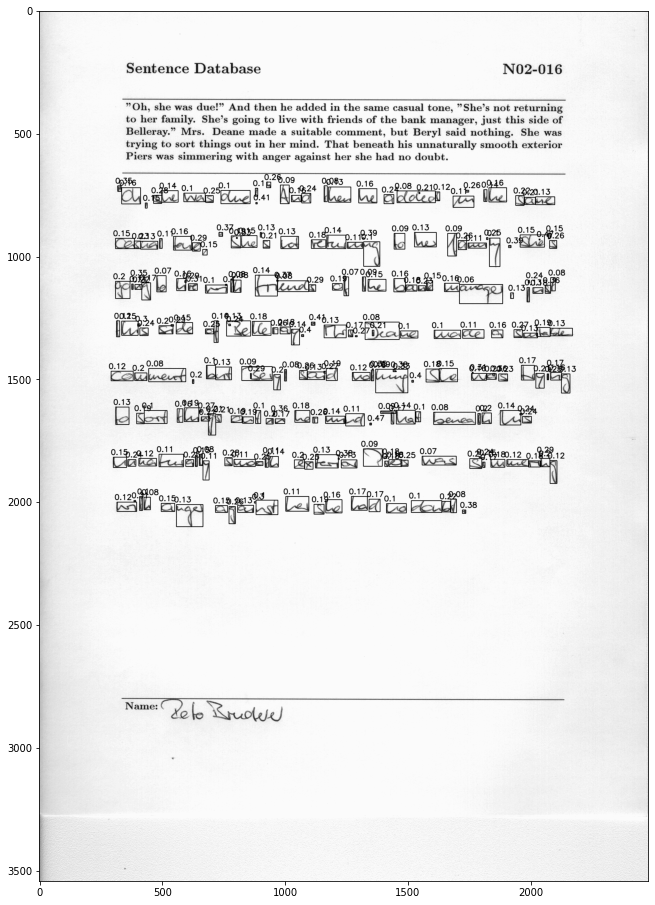

In [76]:
feature = features[randint(0, len(features))]
img = get_img_with_bboxes(feature)
plt.figure(figsize=(16,16))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Extracting chars

In [108]:
def display_chars(img_name):
    plt.figure(figsize=(16,64))
    grid_col_count = 8
    
    # retrieve the image
    img_path = os.path.join(ORIGINAL_FEATURES_DIR, img_name)
    page = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # get the labels
    df_img_labels = df_labels.loc[img_name.replace(".png", "")]
    df_img_labels = df_img_labels
    
    char_count = len(df_img_labels.index)
    
    grid_row_count = char_count / grid_col_count
    if grid_row_count != math.floor(grid_row_count):
        grid_row_count += 1
        
    grid_size = (grid_row_count,grid_col_count)
    
    max_height = df_img_labels['height'].max()
    max_width = df_img_labels['width'].max()
        
    if max_height > max_width:
        img_size = (max_height, max_height)        
    else:
        img_size = (max_width, max_width)
    
    for i in range(0,char_count):
        plt.subplot(grid_size[0],grid_size[1],i+1)
        row = df_img_labels.iloc[i]

        x, y = int(row['x']), int(row['y'])
        width, height = int(row['width']), int(row['height'])

        start_point = (x, y)
        end_point = (x + width, y + height)
        
        color = (0, 0, 0)
        
        patch = page[start_point[1]:end_point[1],start_point[0]:end_point[0]]
        margin_x = math.floor((max_width - width) / 2)
        margin_y = math.floor((max_height - height) / 2)
        
        img = np.full(img_size, 255)        
        
        # copy
        img[margin_y:margin_y + height, margin_x:margin_x + width] = patch                
        img = 255 - img
        
        # strech 
        scale_factor = 
        
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.title(row['ink']) 
        plt.axis('off')
            
    plt.show()

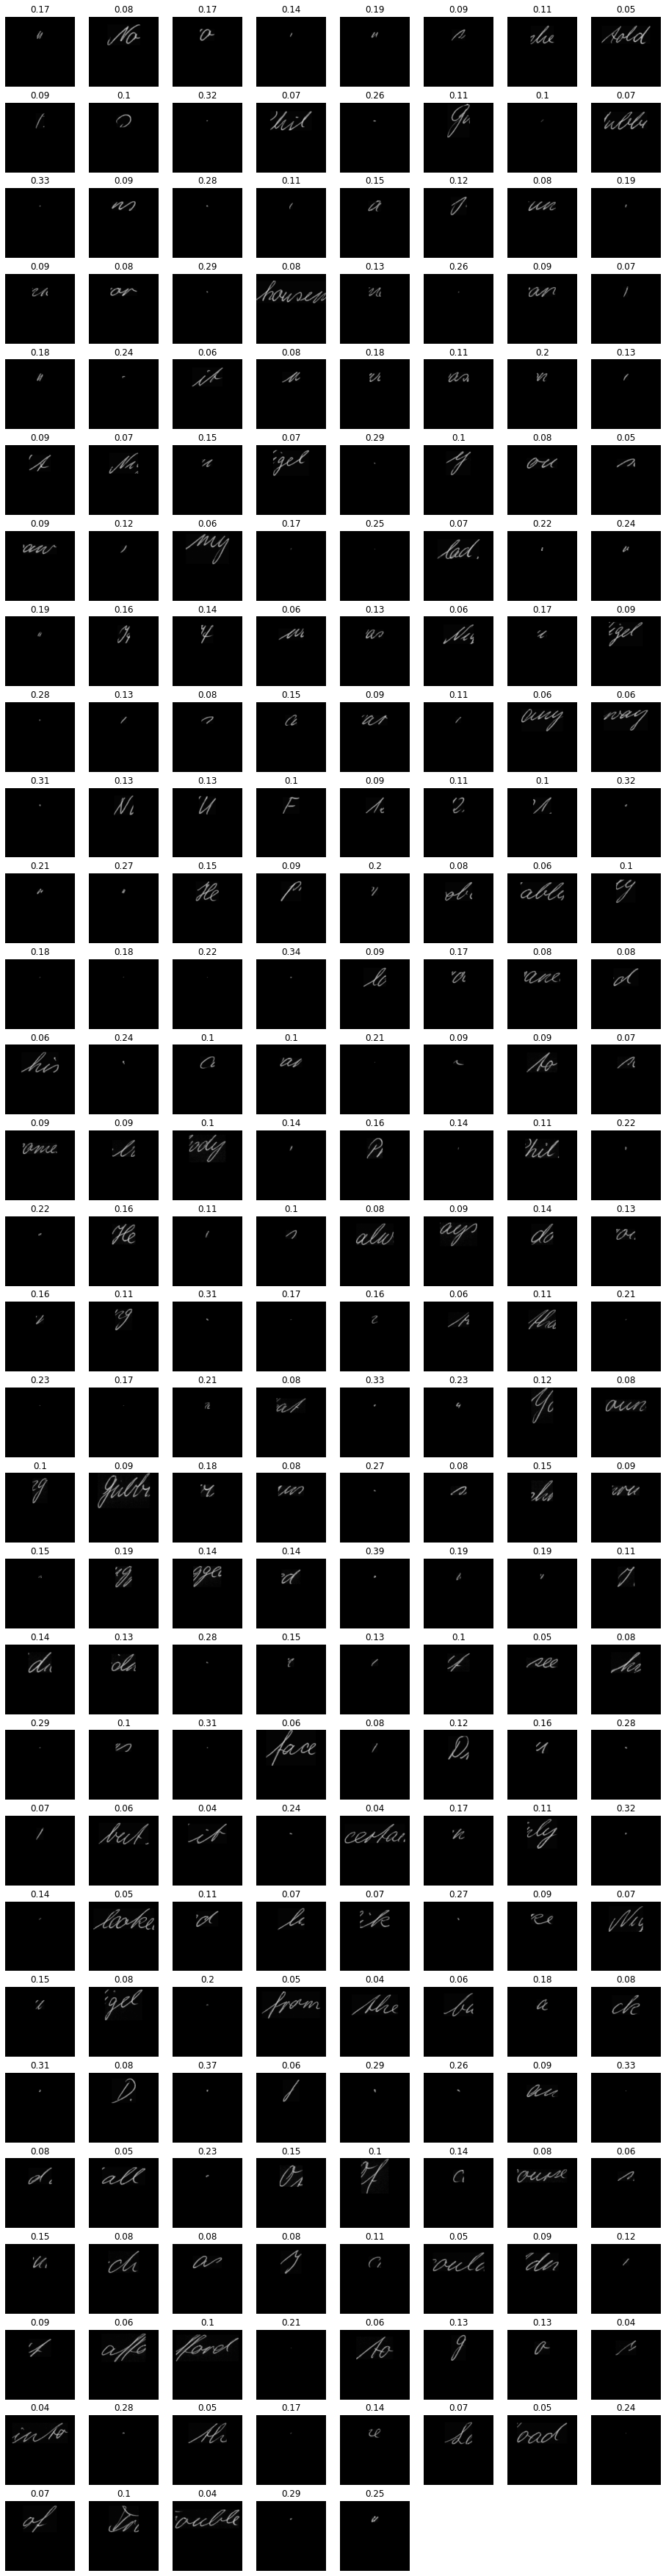

In [109]:
feature = features[randint(0, len(features))]
img = display_chars(feature)